In [17]:
import pandas as pd
import numpy as np
import utilities as u
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [18]:
df_original = pd.read_csv("datasets/fires.csv")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
columns = ["FIRE_NAME", "FIRE_YEAR", "FIRE_SIZE", "DISCOVERY_DATE", "CONT_DATE", "STAT_CAUSE_DESCR", "STATE_NAME", "COUNTY_NAME", "STATE_CODE", "COUNTY_CODE", "LATITUDE", "LONGITUDE", "CONT_TIME"]

In [20]:
df = df_original[columns]
df.head()

,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DATE,CONT_DATE,STAT_CAUSE_DESCR,STATE_NAME,COUNTY_NAME,STATE_CODE,COUNTY_CODE,LATITUDE,LONGITUDE,CONT_TIME
0,TONSINA CREEK,2005,2.3,2005-04-28,2005-04-29,Campfire,Alaska,Kenai Peninsula,2,122,60.053333,-149.440000,2100.0
1,PETERSON CREEK,2005,2.5,2005-05-08,2005-05-10,Miscellaneous,Alaska,Kenai Peninsula,2,122,60.885000,-149.045000,1800.0
2,TWENTY MILE,2005,0.1,2005-05-09,2005-05-09,Debris Burning,Alaska,Kenai Peninsula,2,122,60.861667,-148.995000,1030.0
3,MOTORHOME,2007,0.1,2007-06-01,2007-06-01,Miscellaneous,Alaska,Kenai Peninsula,2,122,60.450278,-149.366944,1640.0
4,POWER,2007,0.1,2007-06-09,2007-06-09,Campfire,Alaska,Kenai Peninsula,2,122,60.466944,-149.700278,1450.0


## Annual AQI plots (over fire duration)

Seems to roughly match the statistics from https://fas.org/sgp/crs/misc/IF10244.pdf for the year 2015

In [21]:
fires_by_year = df.groupby("FIRE_YEAR")

In [22]:
df_aqi = pd.read_csv("datasets/aqi.csv")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
df_aqi['DATE'] = pd.to_datetime(df_aqi['DATE'])
df_aqi['DISCOVERY_DATE'] = df_aqi['DATE']

df_aqi.head()

,STATE_NAME,COUNTY_NAME,STATE_CODE,COUNTY_CODE,DATE,AQI,CATEGORY,DEFINING_PARAMETER,DEFINING_SITE,NUMBER_OF_SITES_REPORTING,YEAR,DISCOVERY_DATE
0,Alabama,Calhoun,1,15,1992-01-01,12,Good,PM10,01-015-0001,1,1992,1992-01-01
1,Alabama,Calhoun,1,15,1992-01-07,28,Good,PM10,01-015-0001,1,1992,1992-01-07
2,Alabama,Calhoun,1,15,1992-01-13,6,Good,PM10,01-015-0001,1,1992,1992-01-13
3,Alabama,Calhoun,1,15,1992-01-19,12,Good,PM10,01-015-0001,1,1992,1992-01-19
4,Alabama,Calhoun,1,15,1992-01-25,13,Good,PM10,01-015-0001,1,1992,1992-01-25


In [24]:
df_fires = df.groupby("FIRE_YEAR").get_group(2006)
df_fires = df_fires.dropna()
df_fires['DISCOVERY_DATE'] = pd.to_datetime(df_fires['DISCOVERY_DATE'])
df_fires['CONT_DATE'] = pd.to_datetime(df_fires['CONT_DATE'])

df_fires['DAYS'] =(df_fires['CONT_DATE'] - df_fires['DISCOVERY_DATE'])/np.timedelta64(1, 'D')
#df_fires = df_fires.rename(columns={'FIPS_STATE':'STATE_CODE', 'FIPS_CODE':'COUNTY_CODE', 'STATE': 'STATE_NAME'})
df_fires.head()


,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DATE,CONT_DATE,STAT_CAUSE_DESCR,STATE_NAME,COUNTY_NAME,STATE_CODE,COUNTY_CODE,LATITUDE,LONGITUDE,CONT_TIME,DAYS
30,HANGER FIRE,2006,0.1,2006-05-23,2006-05-23,Debris Burning,Alaska,Kenai Peninsula,2,122,60.526667,-149.515000,1500.0,0.0
31,DUNLEAVEY FIRE,2006,0.1,2006-05-25,2006-05-25,Debris Burning,Alaska,Kenai Peninsula,2,122,60.521667,-149.481667,815.0,0.0
32,FIRECRACKER,2006,0.1,2006-07-04,2006-07-04,Campfire,Alaska,Kenai Peninsula,2,122,60.483333,-149.906667,1415.0,0.0
33,GWINS FIRE,2006,0.1,2006-07-10,2006-07-10,Campfire,Alaska,Kenai Peninsula,2,122,60.493333,-149.906667,1655.0,0.0
34,MILE 15.5 FIRE,2006,0.1,2006-08-07,2006-08-08,Campfire,Alaska,Kenai Peninsula,2,122,60.303333,-149.363889,1000.0,1.0


In [25]:
## Experimenting
col = []
for n in df_fires.index.values[0:10]:
    col.append(u.get_aqi_avg(df_aqi, df_fires.loc[n], [0, df_fires.loc[n].DAYS], 2006))
col

[8.0, None, 12.0, 10.0, None, 22.0, None, None, None, None]

In [26]:
df_merged = pd.merge(df_fires,df_aqi, on=['STATE_CODE', 'COUNTY_CODE', 'DISCOVERY_DATE'])
df_merged = df_merged.dropna()
df_merged = df_merged[df_merged['FIRE_SIZE'] > 20]

In [27]:
#df_merged[0:3].apply(lambda r: u.get_aqi_change2(df_aqi, r, 2006),axis=1)
col = df_merged[0:2500].apply(lambda r: u.get_aqi_avg(df_aqi,r, [0, r.DAYS], 2006), axis=1)

In [14]:
df_small = pd.DataFrame(df_merged[0:2500])
df_small['AQI_AVG'] = col
df_small.head()

,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DATE,CONT_DATE,STAT_CAUSE_DESCR,STATE_NAME_x,COUNTY_NAME_x,STATE_CODE,COUNTY_CODE,...,STATE_NAME_y,COUNTY_NAME_y,DATE,AQI,CATEGORY,DEFINING_PARAMETER,DEFINING_SITE,NUMBER_OF_SITES_REPORTING,YEAR,AQI_AVG
8,LAKE HOWARD,2006,21.7,2006-06-22,2006-07-01,Arson,Alabama,Talladega,1,121,...,Alabama,Talladega,2006-06-22,90,Moderate,Ozone,01-121-0003,2,2006,81.0
10,MUMP CREEK,2006,57.0,2006-09-09,2006-09-11,Railroad,Alabama,Talladega,1,121,...,Alabama,Talladega,2006-09-09,41,Good,Ozone,01-121-0003,1,2006,45.0
11,TALLADEGA MOUNTAIN,2006,84.0,2006-08-09,2006-08-12,Lightning,Alabama,Talladega,1,121,...,Alabama,Talladega,2006-08-09,71,Moderate,Ozone,01-121-0003,1,2006,56.0
12,MITCHELL,2006,26.0,2006-03-16,2006-03-16,Arson,Alabama,Talladega,1,121,...,Alabama,Talladega,2006-03-16,43,Good,Ozone,01-121-0003,1,2006,43.0
14,SYLACAUGA,2006,265.0,2006-03-17,2006-03-17,Arson,Alabama,Talladega,1,121,...,Alabama,Talladega,2006-03-17,38,Good,Ozone,01-121-0003,1,2006,38.0


Text(0, 0.5, 'Average AQI')

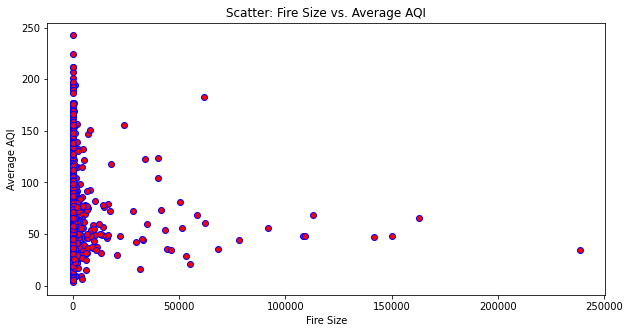

In [15]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 5))

ax1.scatter(x=df_small['FIRE_SIZE'], y=df_small['AQI_AVG'], marker='o', c='r', edgecolor='b')
ax1.set_title('Scatter: Fire Size vs. Average AQI')
ax1.set_xlabel('Fire Size')
ax1.set_ylabel('Average AQI')

In [20]:
df_small_list = list()
for i in range(1992,2016):
    df_fires = df.groupby("FIRE_YEAR").get_group(i)
    df_fires = df_fires.dropna()
    df_fires['DISCOVERY_DATE'] = pd.to_datetime(df_fires['DISCOVERY_DATE'])
    df_fires['CONT_DATE'] = pd.to_datetime(df_fires['CONT_DATE'])

    df_fires['DAYS'] =(df_fires['CONT_DATE'] - df_fires['DISCOVERY_DATE'])/np.timedelta64(1, 'D')
    df_fires = df_fires.rename(columns={'FIPS_STATE':'STATE_CODE', 'FIPS_CODE':'COUNTY_CODE', 'STATE': 'STATE_NAME'})

    df_merged = pd.merge(df_fires,df_aqi, on=['STATE_CODE', 'COUNTY_CODE', 'DISCOVERY_DATE'])
    df_merged = df_merged.dropna()
    df_merged = df_merged[df_merged['FIRE_SIZE'] > 20]
    
    col = df_merged[0:2500].apply(lambda r: u.get_aqi_avg(df_aqi,r, [0, r.DAYS], i), axis=1)

    df_small = pd.DataFrame(df_merged[0:2500])
    df_small['AQI_AVG'] = col
    df_small_list.append(df_small)

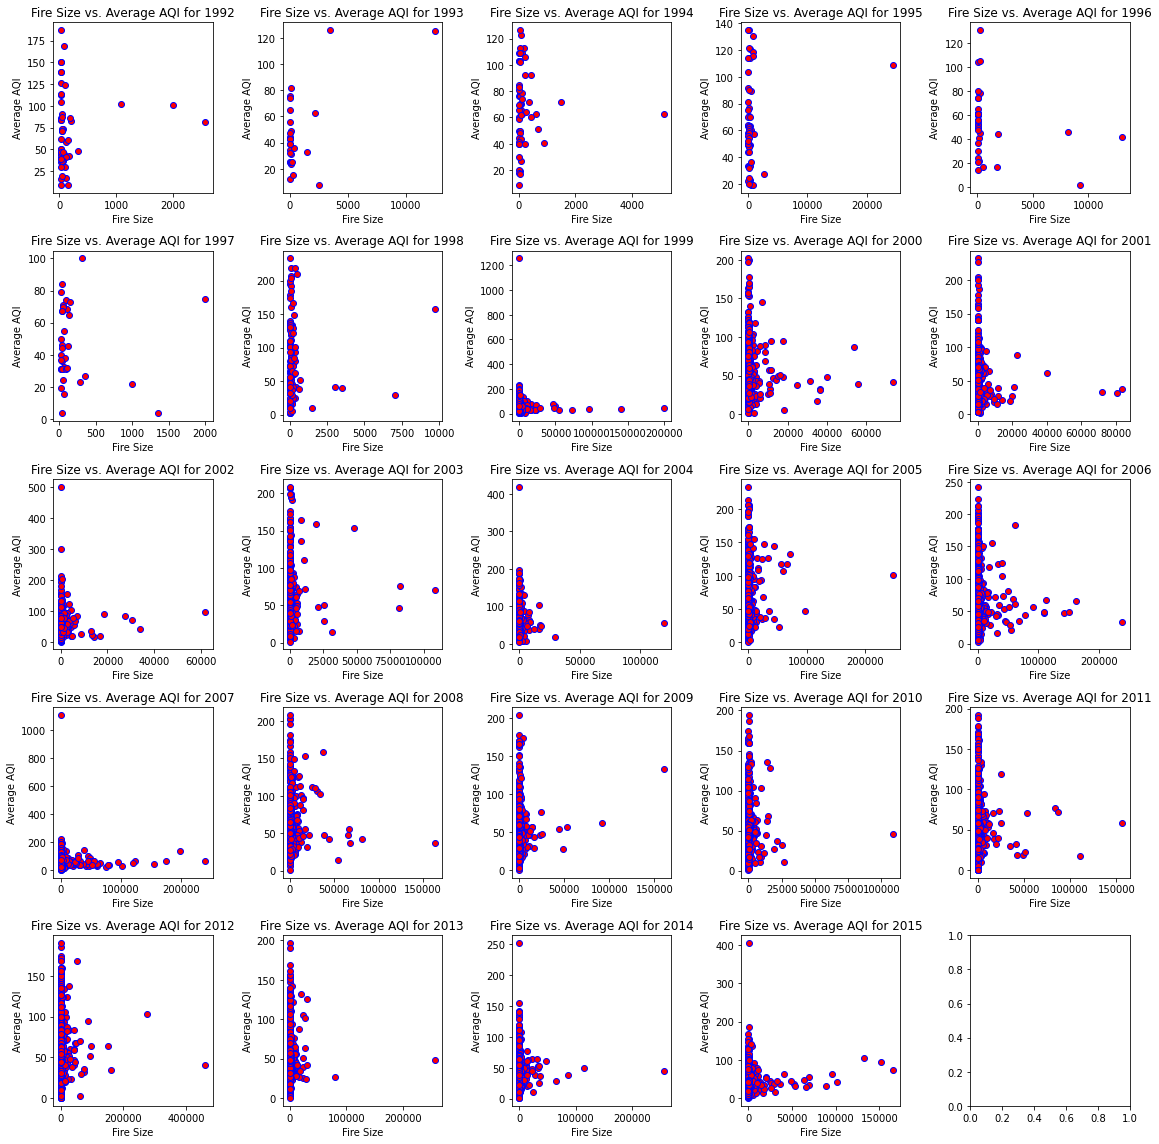

In [23]:
### in one giant loop
fig, ax1 = plt.subplots(5,5, figsize=(16, 16))
ax1 = np.ravel(ax1)
for i in range(1992,2016):
    df_curr = df_small_list[i-1992]
    ax1[i-1992].scatter(x=df_curr['FIRE_SIZE'], y=df_curr['AQI_AVG'], marker='o', c='r', edgecolor='b')
    ax1[i-1992].set_title(f'Fire Size vs. Average AQI for {i}')
    ax1[i-1992].set_xlabel('Fire Size')
    ax1[i-1992].set_ylabel('Average AQI')
    
plt.tight_layout();

### K-Means Clustering

In [98]:
# by fire: latitude, longitude, cont time, aqi/avg_aqi, days, fire_size
# alt: by county: avg aqi, mcc, acres burned by state, # of fires per county
columns = ["LATITUDE", "LONGITUDE", "CONT_TIME", "AQI_AVG", "DAYS", "FIRE_SIZE"]
df_new = df_small[columns]
df_new.head()

,LATITUDE,LONGITUDE,CONT_TIME,AQI_AVG,DAYS,FIRE_SIZE
8,33.208889,-86.208889,1600.0,81.0,9.0,21.7
10,33.371111,-86.018056,1602.0,45.0,2.0,57.0
11,33.332778,-86.007222,1200.0,56.0,3.0,84.0
12,33.537500,-85.819167,1030.0,43.0,0.0,26.0
14,33.247586,-86.371107,1729.0,38.0,0.0,265.0


In [99]:
X_std = StandardScaler().fit_transform(df_new)

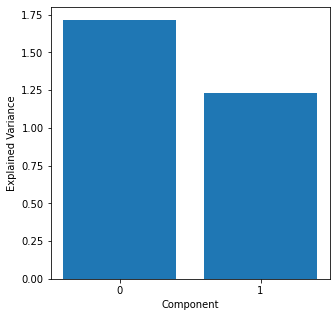

In [100]:
pca = PCA(n_components=2)
pca.fit(X_std)

f = range(pca.n_components_)
plt.figure(figsize=(5,5))
plt.bar(f, pca.explained_variance_)
plt.xticks(f)
plt.ylabel('Explained Variance')
plt.xlabel('Component')
plt.show()

In [101]:
pca_data = pca.transform(X_std)
df_pca = pd.DataFrame(pca_data)

In [102]:
# Fit Kmeans and calculate SSE for each k value
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df_pca)
    sse[k] = kmeans.inertia_ # sum of squared distances to the closest cluster centers

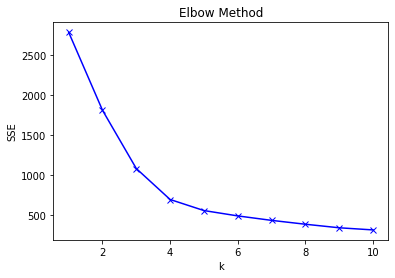

In [103]:
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.show()

In [104]:
## Elbow at K = 4
kmeans = KMeans(n_clusters=4, random_state=614)
kmeans.fit(pca_data)
df_pca = df_pca.assign(cluster=kmeans.labels_)
df_kmeans = df_small.assign(cluster=kmeans.labels_)

In [105]:
df_kmeans.head()

,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DATE,CONT_DATE,STAT_CAUSE_DESCR,STATE_NAME_x,COUNTY_NAME_x,STATE_CODE,COUNTY_CODE,...,COUNTY_NAME_y,DATE,AQI,CATEGORY,DEFINING_PARAMETER,DEFINING_SITE,NUMBER_OF_SITES_REPORTING,YEAR,AQI_AVG,cluster
8,LAKE HOWARD,2006,21.7,2006-06-22,2006-07-01,Arson,Alabama,Talladega,1,121,...,Talladega,2006-06-22,90,Moderate,Ozone,01-121-0003,2,2006,81.0,1
10,MUMP CREEK,2006,57.0,2006-09-09,2006-09-11,Railroad,Alabama,Talladega,1,121,...,Talladega,2006-09-09,41,Good,Ozone,01-121-0003,1,2006,45.0,1
11,TALLADEGA MOUNTAIN,2006,84.0,2006-08-09,2006-08-12,Lightning,Alabama,Talladega,1,121,...,Talladega,2006-08-09,71,Moderate,Ozone,01-121-0003,1,2006,56.0,1
12,MITCHELL,2006,26.0,2006-03-16,2006-03-16,Arson,Alabama,Talladega,1,121,...,Talladega,2006-03-16,43,Good,Ozone,01-121-0003,1,2006,43.0,1
14,SYLACAUGA,2006,265.0,2006-03-17,2006-03-17,Arson,Alabama,Talladega,1,121,...,Talladega,2006-03-17,38,Good,Ozone,01-121-0003,1,2006,38.0,1


In [106]:
df_kmeans.cluster.value_counts() ## dominance of one cluster, but that's ok.

0    483
2    185
1    154
3    124
Name: cluster, dtype: int64

Text(0.5, 1.0, 'PCA1 vs. PCA2')

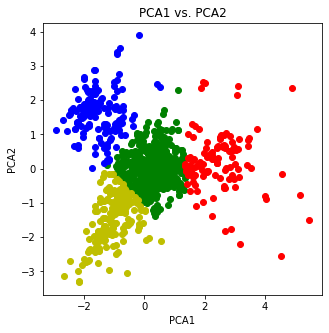

In [107]:
pca_arr = df_pca.values
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(pca_arr[kmeans.labels_ == 0,0], pca_arr[kmeans.labels_ == 0,1], c= 'g', label="Cluster 1")
plt.scatter(pca_arr[kmeans.labels_ == 1,0], pca_arr[kmeans.labels_ == 1,1], c= 'b', label="Cluster 2")
plt.scatter(pca_arr[kmeans.labels_ == 2,0], pca_arr[kmeans.labels_ == 2,1], c= 'y', label="Cluster 3")
plt.scatter(pca_arr[kmeans.labels_ == 3,0], pca_arr[kmeans.labels_ == 3,1], c= 'r', label="Cluster 4")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA1 vs. PCA2')



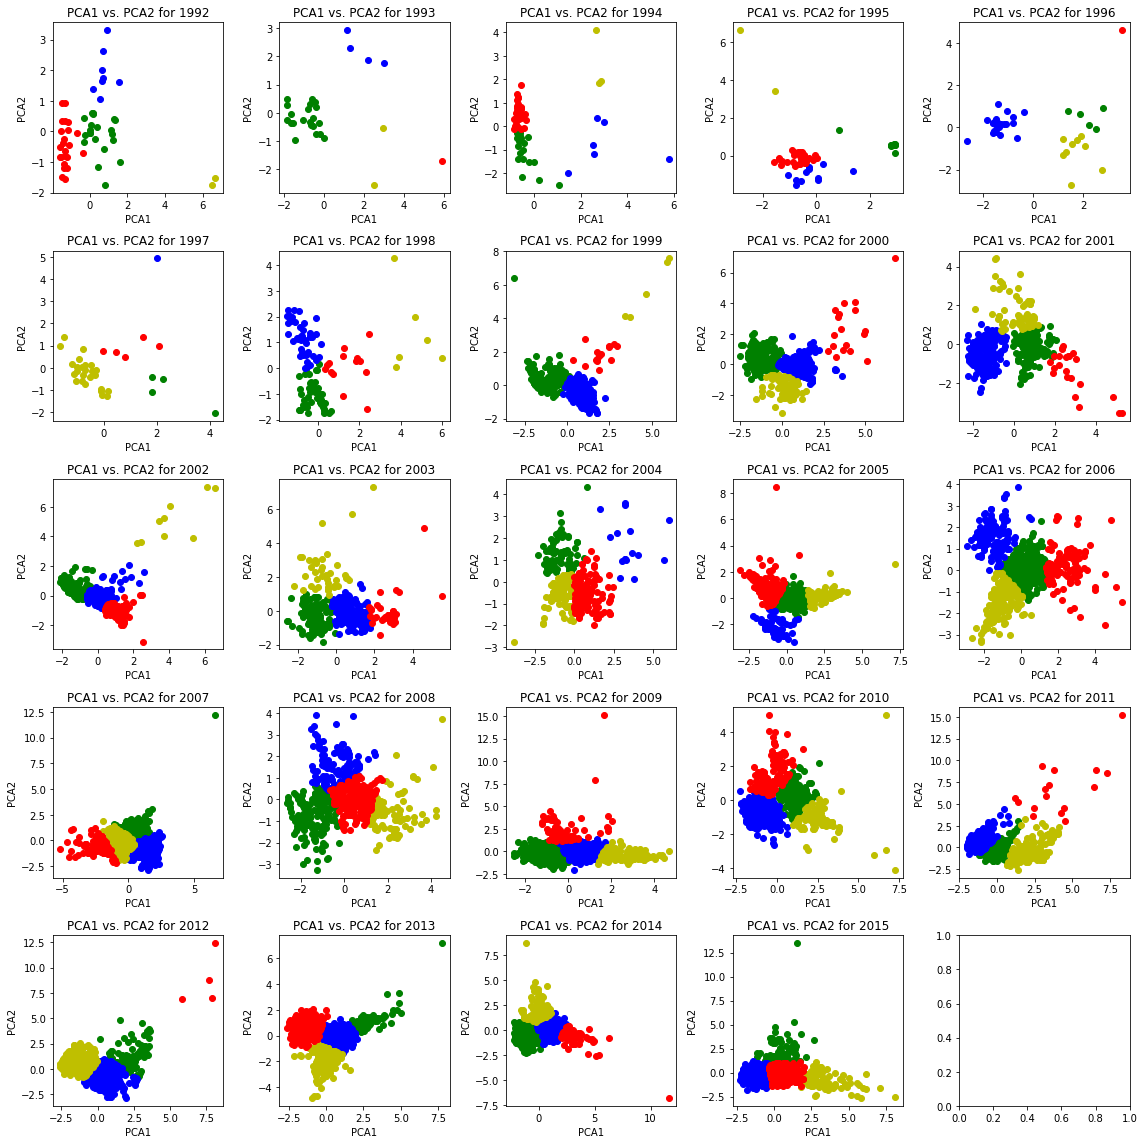

In [33]:
columns = ["LATITUDE", "LONGITUDE", "CONT_TIME", "AQI_AVG", "DAYS", "FIRE_SIZE"]
fig, ax1 = plt.subplots(5,5, figsize=(16, 16))
ax1 = np.ravel(ax1)
for i in range(1992,2016):
    df_now = df_small_list[i-1992]
    df_new = df_now[columns]
    
    X_std = StandardScaler().fit_transform(df_new)

    pca = PCA(n_components=2)
    pca.fit(X_std)

    pca_data = pca.transform(X_std)
    df_pca = pd.DataFrame(pca_data)

    kmeans = KMeans(n_clusters=4, random_state=614)
    kmeans.fit(pca_data)

    df_pca = df_pca.assign(cluster=kmeans.labels_)
    df_kmeans = df_now.assign(cluster=kmeans.labels_)
    
    pca_arr = df_pca.values
    ax1[i-1992].scatter(pca_arr[kmeans.labels_ == 0,0], pca_arr[kmeans.labels_ == 0,1], c= 'g', label="Cluster 1")
    ax1[i-1992].scatter(pca_arr[kmeans.labels_ == 1,0], pca_arr[kmeans.labels_ == 1,1], c= 'b', label="Cluster 2")
    ax1[i-1992].scatter(pca_arr[kmeans.labels_ == 2,0], pca_arr[kmeans.labels_ == 2,1], c= 'y', label="Cluster 3")
    ax1[i-1992].scatter(pca_arr[kmeans.labels_ == 3,0], pca_arr[kmeans.labels_ == 3,1], c= 'r', label="Cluster 4")
    ax1[i-1992].set_xlabel('PCA1')
    ax1[i-1992].set_ylabel('PCA2')
    ax1[i-1992].set_title(f'PCA1 vs. PCA2 for {i}')

plt.tight_layout()

In [36]:
# by fire: latitude, longitude, cont time, aqi/avg_aqi, days, fire_size
# alt: by county: avg aqi, mcc, acres burned by state, # of fires per county
columns = ["FIRE_SIZE", "AQI_AVG"]
df_new = df_small_list[14][columns]
df_new.head()

,FIRE_SIZE,AQI_AVG
8,21.7,81.0
10,57.0,45.0
11,84.0,56.0
12,26.0,43.0
14,265.0,38.0


In [37]:
# Fit Kmeans and calculate SSE for each k value
sse = {}
X_std = StandardScaler().fit_transform(df_new)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=614)
    kmeans.fit(X_std)
    sse[k] = kmeans.inertia_ # sum of squared distances to the closest cluster centers

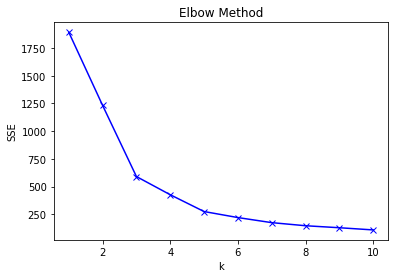

In [38]:
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.show()

In [39]:
## Elbow at K = 3
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X_std)
df_new = pd.DataFrame(X_std)
df_kmeans = df_new.assign(cluster=kmeans.labels_)

Text(0.5, 1.0, 'K-Means Analysis')

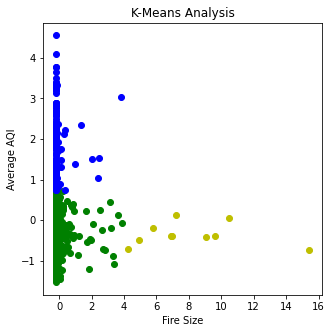

In [40]:
pca_arr = df_kmeans.values
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(pca_arr[kmeans.labels_ == 0,0], pca_arr[kmeans.labels_ == 0,1], c= 'g', label="Cluster 1")
plt.scatter(pca_arr[kmeans.labels_ == 1,0], pca_arr[kmeans.labels_ == 1,1], c= 'b', label="Cluster 2")
plt.scatter(pca_arr[kmeans.labels_ == 2,0], pca_arr[kmeans.labels_ == 2,1], c= 'y', label="Cluster 3")
plt.xlabel('Fire Size')
plt.ylabel('Average AQI')
plt.title('K-Means Analysis')



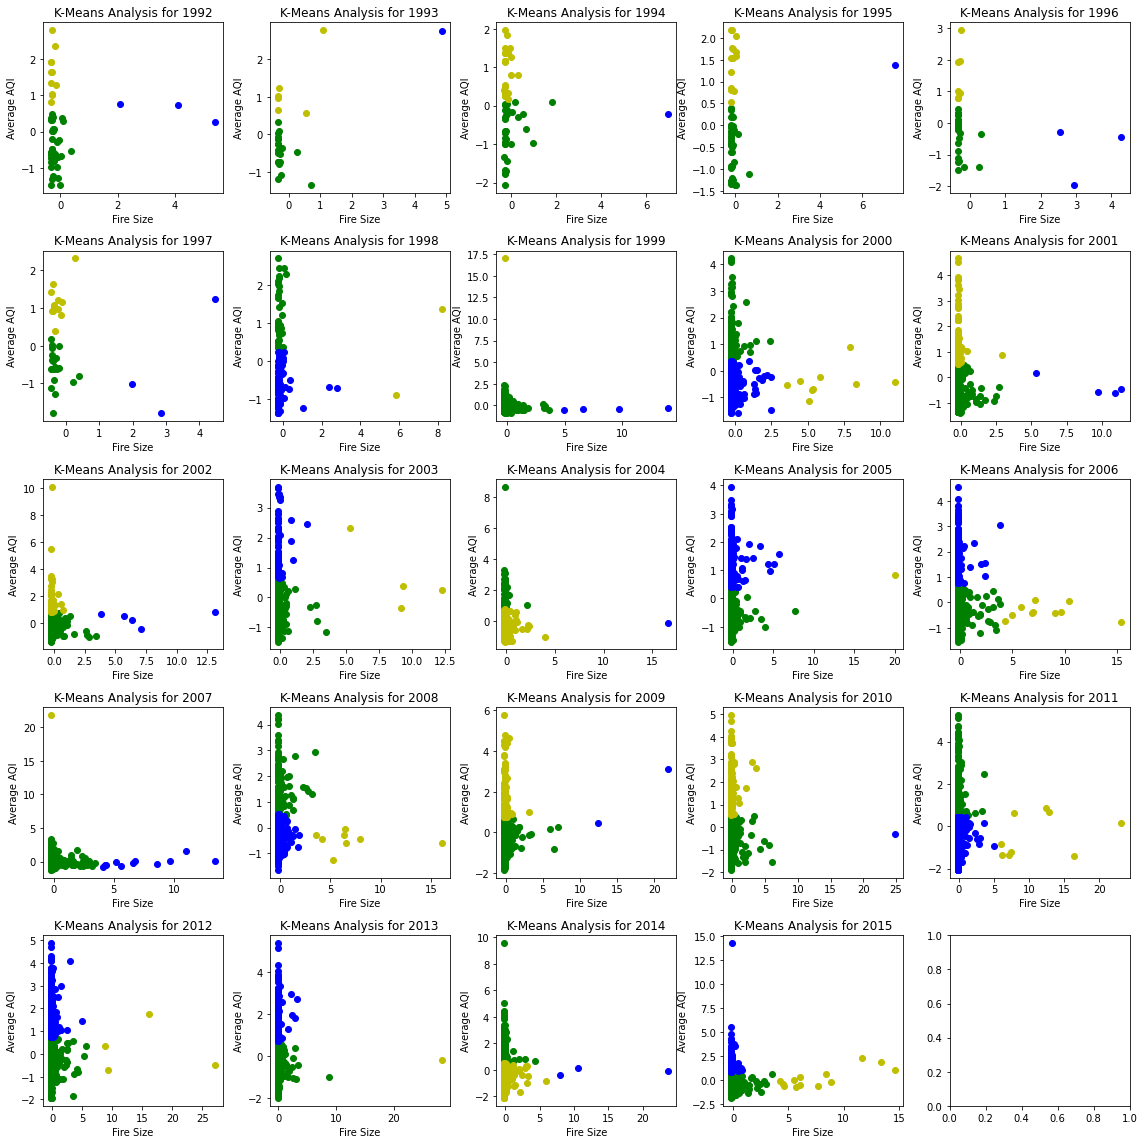

In [41]:
columns = ["FIRE_SIZE", "AQI_AVG"]
fig, ax1 = plt.subplots(5,5, figsize=(16, 16))
ax1 = np.ravel(ax1)
    
for i in range(1992,2016):
    df_now = df_small_list[i-1992]
    df_new = df_now[columns]
    
    X_std = StandardScaler().fit_transform(df_new)

    kmeans = KMeans(n_clusters=3, random_state=614)
    kmeans.fit(X_std)

    df_new = pd.DataFrame(X_std)
    df_kmeans = df_new.assign(cluster=kmeans.labels_)
    pca_arr = df_kmeans.values
    
    ax1[i-1992].scatter(pca_arr[kmeans.labels_ == 0,0], pca_arr[kmeans.labels_ == 0,1], c= 'g', label="Cluster 1")
    ax1[i-1992].scatter(pca_arr[kmeans.labels_ == 1,0], pca_arr[kmeans.labels_ == 1,1], c= 'b', label="Cluster 2")
    ax1[i-1992].scatter(pca_arr[kmeans.labels_ == 2,0], pca_arr[kmeans.labels_ == 2,1], c= 'y', label="Cluster 3")
    ax1[i-1992].set_xlabel('Fire Size')
    ax1[i-1992].set_ylabel('Average AQI')
    ax1[i-1992].set_title(f'K-Means Analysis for {i}')

plt.tight_layout()